# Preprocessing

In [12]:
# import packages
import pandas as pd
import numpy as np
import datetime

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

# NLP packages
import string, re
import spacy, re
import en_core_web_sm
from spacy.lang.en import English
from spacy import displacy
from textblob import TextBlob
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# scikitlearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# optimize viewing
pd.set_option('max_colwidth', 150)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidbruce/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [194]:
# read in cleaned dataframe
df = pd.read_csv('./data/clean_df.csv')

In [195]:
df = df.drop(labels=['Unnamed: 0'], axis=1)

In [196]:
df.shape

(77259, 7)

In [197]:
# convert date to datetime object
df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

# convert datetime to string without timestamp
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

# convert date back to datetime
df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

## VADER Sentiment Classification

In [198]:
# use vader compound (or composite) score to evaluate the tweet sentiment
vader = SentimentIntensityAnalyzer()

df['vader_score'] = df['tweet'].apply(lambda x: vader.polarity_scores(x)['compound'])

In [199]:
# classify tweets based on their vader score less than -.05 'negative', greater than .05 'positive'
# 'neutral' in between
conditions = [
    df['vader_score'] >= .05,
    df['vader_score'] <= -.05
]

classes = ['positive', 'negative']

df['vader_sentiment'] = np.select(conditions, classes, 'neutral')

In [200]:
# breakdown of classes
df.vader_sentiment.value_counts()

positive    31095
negative    25703
neutral     20461
Name: vader_sentiment, dtype: int64

In [201]:
# breakdown of classes by %
df.vader_sentiment.value_counts(normalize=True)

positive    0.402477
negative    0.332686
neutral     0.264836
Name: vader_sentiment, dtype: float64

In [202]:
# drop the 'vader_score' column
# df = df.drop(labels='vader_score', axis=1)

## TextBlob Sentiment Classification

In [203]:
# textBlob
df['tweet_blob'] = df['tweet'].apply(lambda x: TextBlob(x))

In [204]:
df['blob_sent_score'] = df['tweet_blob'].apply(lambda x: x.sentiment.polarity)

In [205]:
conditions = [
    df['blob_sent_score'] >= .05,
    df['blob_sent_score'] <= -.05
]

classes = ['positive', 'negative']

df['blob_sentiment'] = np.select(conditions, classes, 'neutral')

In [206]:
df.blob_sentiment.value_counts()

positive    33748
neutral     30485
negative    13026
Name: blob_sentiment, dtype: int64

In [207]:
df.blob_sentiment.value_counts(normalize=True)

positive    0.436816
neutral     0.394582
negative    0.168602
Name: blob_sentiment, dtype: float64

In [208]:
df['blob_subj'] = df['tweet_blob'].apply(lambda x: x.sentiment.subjectivity)

In [209]:
# df = df.drop(labels = ['tweet_blob', 'blob_sent_score'], axis=1)

## Where do TextBlob and VADER agree/disagree?

In [210]:
df[df['vader_sentiment'] == df['blob_sentiment']].shape

(40320, 13)

In [211]:
df['agree'] = df['vader_sentiment'] == df['blob_sentiment']

In [212]:
df['agree'] = df['agree'].astype(int)

In [213]:
# how many of these differences in opinion are disagreements? How many are simply more ambiguous and 
# classified as neutral rather than positive/negative?

In [214]:
# averaging out the scores -  this is too simplified, need to complicate the logic here
df['overall_score'] = (df['vader_score'] + df['blob_sent_score'])/2

In [215]:
conditions = [
    df['overall_score'] >= .05,
    df['overall_score'] <= -.05
]

classes = ['positive', 'negative']

df['overall_sentiment'] = np.select(conditions, classes, 'neutral')

In [216]:
df.overall_sentiment.value_counts()

positive    35721
negative    24155
neutral     17383
Name: overall_sentiment, dtype: int64

In [217]:
df.overall_sentiment.value_counts(normalize=True)

positive    0.462354
negative    0.312650
neutral     0.224996
Name: overall_sentiment, dtype: float64

In [218]:
print(df.vader_sentiment.value_counts(normalize=True), '\n',
      df.blob_sentiment.value_counts(normalize=True), '\n', 
      df.overall_sentiment.value_counts(normalize=True)
     )

positive    0.402477
negative    0.332686
neutral     0.264836
Name: vader_sentiment, dtype: float64 
 positive    0.436816
neutral     0.394582
negative    0.168602
Name: blob_sentiment, dtype: float64 
 positive    0.462354
negative    0.312650
neutral     0.224996
Name: overall_sentiment, dtype: float64


## Cleaning tweets for visuals and tfidf
[Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)

In [219]:
# remove handles
def remove_handles(text, pattern):
    r = re.findall(pattern, text)
    for i in r:
        text = re.sub(i, '', text)
    return text

In [220]:
df['tidy_tweet'] = np.vectorize(remove_handles)(df['tweet'], '@[\w]*')

In [221]:
# remove special characters
df['tidy_tweet'] = df['tidy_tweet'].str.replace('[^a-zA-Z#]', ' ')

In [222]:
# lowercase and tokenize
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.lower().split())

In [223]:
# stopword removal
stopwords = nltk.corpus.stopwords.words('english')

# need to add esoteric words that don't help
stopwords += ['covid', '#covid', 'vaccine', 'vaccine', 'coronavirus', '#coronavirus']

In [224]:
# lemmatize and remove stopwords
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmer.lemmatize(word) for word in x if word not in stopwords])

In [225]:
# lemmatize - do i need to do POS tagging here?
lemmer = WordNetLemmatizer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmer.lemmatize(i) for i in x])

In [226]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['tidy_tweet'] = tokenized_tweet

In [227]:
df['tidy_tweet'].head()

0          everyone comparing flu reminder even vaccine flu kill ten thousand year imagine deadly virus assurance developed affordable hi welcome pandemic
1    perhaps type medicine success #vaccine depends cooperation everyone protect young immunocompromised need massive buy population large #covid #coro...
2                                     provide pharmaceutical company opportunity develop drug soon possible reach mass production know drug produced later
3          john hopkins immediate risk remains low u best way protect practicing precaution would use prevent spread respiratory disease currently prevent
4                                                                          #stockmarkets keep falling confident #vaccine #covid fund available development
Name: tidy_tweet, dtype: object

### visualizations

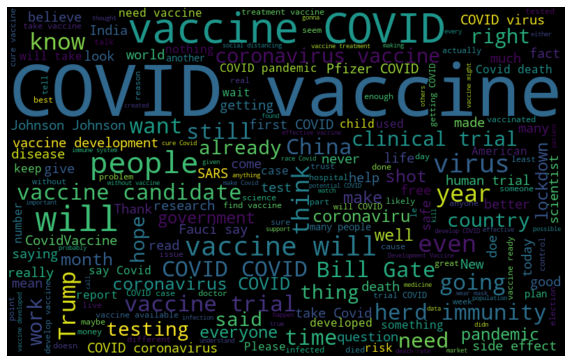

In [59]:
all_words = ' '.join([text for text in df['tidy_tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('images/first_cloud.png');

(-0.5, 799.5, 499.5, -0.5)

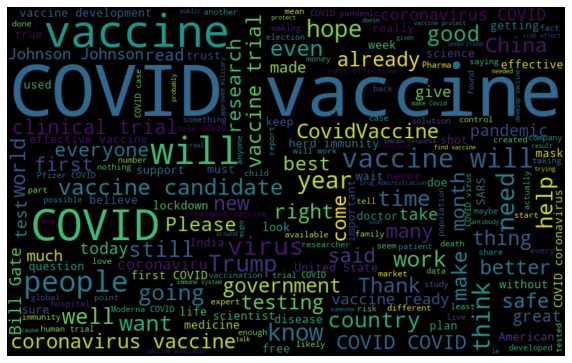

In [64]:
positive_tweets = ' '.join([text for text in df['tidy_tweet'][df['sentiment'] == 'positive']])

wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(positive_tweets)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('images/positive_cloud.png');

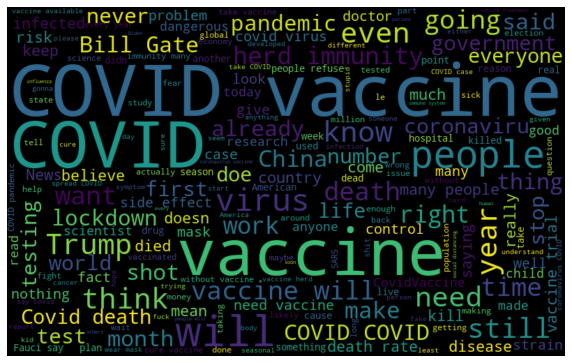

In [61]:
negative_tweets = ' '.join([text for text in df['tidy_tweet'][df['sentiment'] == 'negative']])

wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(negative_tweets)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('images/negative_cloud.png');

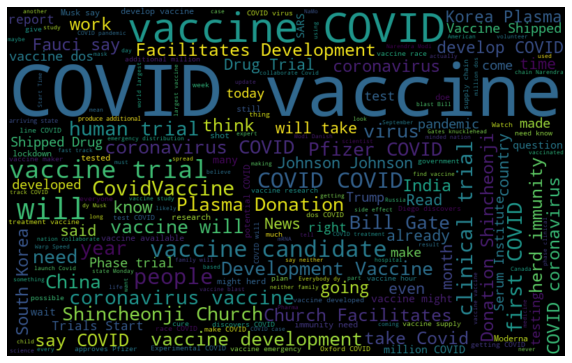

In [62]:
neutral_tweets = ' '.join([text for text in df['tidy_tweet'][df['sentiment'] == 'neutral']])

wordcloud = WordCloud(width=800, height=500, random_state=88, max_font_size=110).generate(neutral_tweets)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.savefig('images/neutral_cloud.png');

In [74]:
stopwords = set(stopwords.words('english'))
print(stopwords)

{"couldn't", "haven't", 'each', 'd', 'we', 'who', 'after', 'again', 'themselves', 'be', 'further', 'mightn', "shan't", 'can', 'won', 'other', 'most', 'has', 'more', "mustn't", "weren't", 'there', "needn't", 'theirs', 'until', 'any', 'and', 'not', 'then', 'him', 'some', 'were', 'down', 'itself', 'once', 'didn', 'ma', 'weren', "hasn't", 'under', 'to', 'above', 'only', 'where', "you'll", 'himself', 'had', 'yourself', 'yourselves', 'between', 's', 'doing', "should've", 'is', 'same', 'hadn', "you've", 'no', 'she', 'needn', 'an', "it's", 'the', 'into', 'over', 'now', 'did', 'how', 'being', 'am', 'all', 'y', 'very', 'do', 'isn', "won't", 'which', 'these', "wasn't", 'here', 'about', 'myself', 'when', 'own', 'you', 'as', 'up', 'my', 'before', 'having', 'doesn', "wouldn't", 'against', 'hasn', 'me', 'their', 'by', 'are', 'or', 'just', 'because', 'if', "didn't", 'have', "you're", 'few', 've', "mightn't", 'too', 'of', "hadn't", "she's", 'it', 'through', 'they', 'aren', 'm', 'for', "aren't", 'does',

### Remove stopwords (check wordclouds without stopwords as well)

### Word FreqDists

### Sentiment over time

## Sklearn 

In [16]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [18]:
tf = TfidfVectorizer(lowercase=True, tokenizer=token.tokenize)
text_tf = tf.fit_transform(df['tweet'])
text_tf.data

array([0.13545827, 0.2371028 , 0.24071474, ..., 0.03735544, 0.02551469,
       0.0518535 ])

In [19]:
len(text_tf.data)

2169940

In [21]:
def tfidf(docs, xColNames=None):
    tf = TfidfVectorizer(tokenizer=token.tokenize)
    x1 = tf.fit_transform(docs)
    
    df = pd.DataFrame(x1.toarray().transpose(), index=tf.get_feature_names())
    
    if xColNames is not None:
        df.columns = xColNames
    
    return df

In [23]:
sparse = tfidf(df['tweet']).transpose()

In [25]:
sparse.shape

(77259, 122638)

In [26]:
sparse.iloc[:,100000:100050]

,st0szsenxb,st1,st2c9gbymp,st2fta0kyx,st3dyclmot,st3u6o4zgh,st3v3nparker,st4hptjjcu,st57mmn5g5,st8vritmdz,...,stacked,stacking,stacy,stacyherbert,stacymangia15,stacymcgregor14,stacyontheright,stacysadar,stacyshafer6,stacystranghour
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
##### text classification from Intro_to_NLP #####

In [35]:
data = df['tweet']
target = df['sentiment']

In [40]:
stopwords = stopwords.words('english')

In [41]:
stopwords += list(string.punctuation)

In [42]:
stopwords = set(stopwords)

In [44]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords]
    return stopwords_removed

In [45]:
processed_data = list(map(process_tweet, data))

In [49]:
total_vocab = set()
for tweet in processed_data:
    total_vocab.update(tweet)
len(total_vocab)

139512

In [52]:
lemmatizer = WordNetLemmatizer()

In [53]:
lemmatized_output = []

for listy in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [54]:
X_lem = lemmatized_output
y_lem = target

In [63]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, random_state=88)
tfidf = TfidfVectorizer()

In [64]:
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)

In [65]:
tfidf_data_test_lem = tfidf.transform(X_test_lem)

In [66]:
tfidf_data_train_lem

<57944x97613 sparse matrix of type '<class 'numpy.float64'>'
	with 1050101 stored elements in Compressed Sparse Row format>

In [68]:
non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print('Average # of Non-Zero elements in Vectorized Tweets: ', non_zero_cols)

Average # of Non-Zero elements in Vectorized Tweets:  18.12268742233881


In [69]:
percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of cols containing ZERO: ', percent_sparse)

Percentage of cols containing ZERO:  0.9998143414563394


In [70]:
df_freq_pos = df[df['sentiment'] == 'positive']
df_freq_neu = df[df['sentiment'] == 'neutral']
df_freq_neg = df[df['sentiment'] == 'negative']

In [71]:
data_pos = df_freq_pos['tweet']
data_neu = df_freq_neu['tweet']
data_neg = df_freq_neg['tweet']

In [73]:
data_pos.head()

1    “Perhaps more than any other type of medicine, the success of a #vaccine depends on the cooperation of everyone. To protect those who can’t have a...
2    Provide pharmaceutical companies with the opportunity to develop this vaccine and drug as soon as possible and to reach mass production. As you kn...
3    From John's Hopkins: 1)  Immediate risk of COVID-19 remains low in the U.S.  The best way to protect yourself is by practicing the same precaution...
4            If the #stockmarkets keep falling - how confident will you be about a #vaccine for #COVID-19 and funds being available for their development?
5    The Jefferson County Department of Health (@jcdhtweets)  says they're working with local schools and hospitals to prepare for the spread of COVID-...
Name: tweet, dtype: object

In [72]:
pros_pos = list(map(process_tweet, data_pos))
pros_neu = list(map(process_tweet, data_neu))
pros_neg = list(map(process_tweet, data_neg))

TypeError: argument of type 'WordListCorpusReader' is not iterable

## SpaCy NLP Preprocessing

#### Tokenizing

In [27]:
# while the sentiment in this tweet is properly classified as 'negative',
# this person is likely in favor of taking a vaccine, and the negative 
# sentiment is more broadly directed at the context of COVID-19
print(df.loc[0]['tweet'],'\n')
print(df.loc[0]['sentiment'])

For everyone comparing COVID-19 to the flu, just a reminder that even with vaccines the flu kills tens of thousands a year. Now imagine a more deadly virus with no vaccine or assurance that any vaccine developed will be affordable and hi! Welcome to the pandemic! 

negative


In [178]:
# instantiate spaCy English object
nlp = English()

text = df.loc[0]['tweet']

my_doc = nlp(text)

token_list = []
for token in my_doc:
    token_list.append(token.text)
print(token_list)

['For', 'everyone', 'comparing', 'COVID-19', 'to', 'the', 'flu', ',', 'just', 'a', 'reminder', 'that', 'even', 'with', 'vaccines', 'the', 'flu', 'kills', 'tens', 'of', 'thousands', 'a', 'year', '.', 'Now', 'imagine', 'a', 'more', 'deadly', 'virus', 'with', 'no', 'vaccine', 'or', 'assurance', 'that', 'any', 'vaccine', 'developed', 'will', 'be', 'affordable', 'and', 'hi', '!', 'Welcome', 'to', 'the', 'pandemic', '!']


#### Stopwords

In [179]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

filtered_sent = []

doc = nlp(text)

for word in doc:
    if word.is_stop == False:
        filtered_sent.append(word)
print(filtered_sent)

[comparing, COVID-19, flu, ,, reminder, vaccines, flu, kills, tens, thousands, year, ., imagine, deadly, virus, vaccine, assurance, vaccine, developed, affordable, hi, !, Welcome, pandemic, !]


#### Lemmatization

In [30]:
for word in filtered_sent:
    print(word.text, word.lemma_)

comparing compare
COVID-19 COVID-19
flu flu
, ,
reminder reminder
vaccines vaccine
flu flu
kills kill
tens ten
thousands thousand
year year
. .
imagine imagine
deadly deadly
virus virus
vaccine vaccine
assurance assurance
vaccine vaccine
developed develope
affordable affordable
hi hello
! !
Welcome Welcome
pandemic pandemic
! !


In [31]:
nlp = en_core_web_sm.load()



for word in my_doc:
    print(word.text, word.pos_)

For 
everyone 
comparing 
COVID-19 
to 
the 
flu 
, 
just 
a 
reminder 
that 
even 
with 
vaccines 
the 
flu 
kills 
tens 
of 
thousands 
a 
year 
. 
Now 
imagine 
a 
more 
deadly 
virus 
with 
no 
vaccine 
or 
assurance 
that 
any 
vaccine 
developed 
will 
be 
affordable 
and 
hi 
! 
Welcome 
to 
the 
pandemic 
! 
